# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


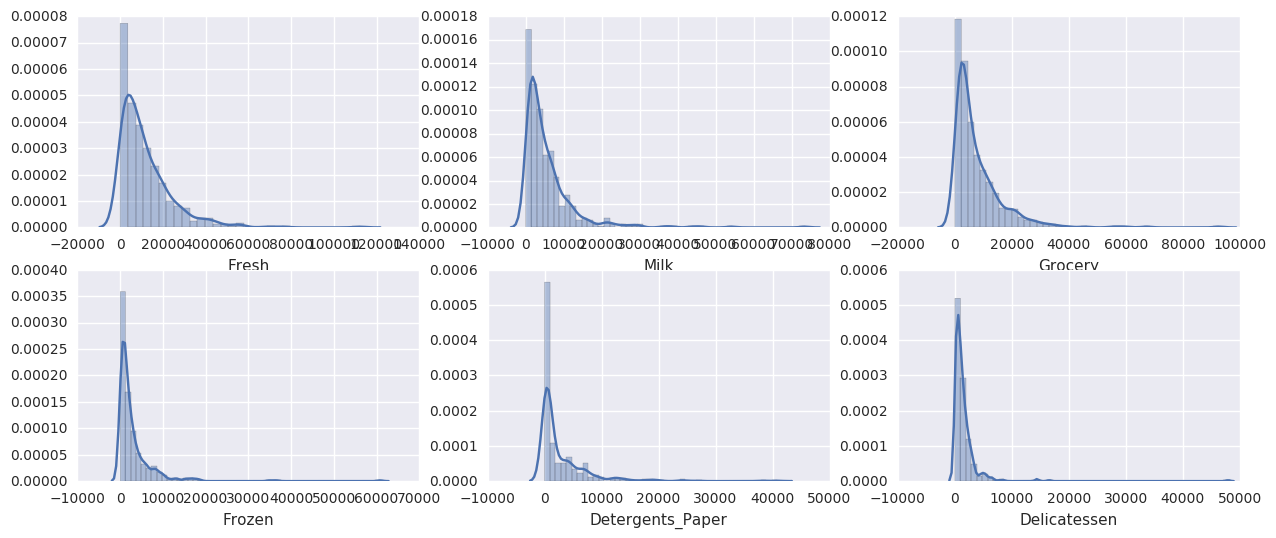

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
# Display a description of the dataset

display(data.describe())
fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(6):
    col = data.columns[i]
    sns.distplot(data[col], ax=axs[i])

### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [3]:
# Select three indices of your choice you wish to sample from the dataset
rand_state_c = 65535
rng = np.random.RandomState(rand_state_c)
indices = rng.randint(1,data.shape[0]+1,3)

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,200,25862,19816,651,8773,6250
1,694,8533,10518,443,6907,156
2,7149,2428,699,6316,395,911


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**<br>
1. First customer seems like a hypermarket because the first customer purchases a lot of milk for making drinks, the customer spends around 75% and more range over milk. And the customer also purchases around 75% and more range over grocery, but the customer just purchases fresh and frozen that less 25% range, therefore the customer process foods rarely. The intuition above shows the first customer might be a coffeehouse chains.
2. 2nd customer seems a grocery store because the customer spends around 75% range milk, grocery and Detergents_Paper, and the customer spends foods that less 25% range.
3. 3rd customer seems like a restaurant because 3rd customer purchases around 50% range foods, but the customer just purchases around 25% range ready-made(inculding milk), and the customer purchases grocery that less 25% range, therefore the customer mainly process foods. 

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

{'Grocery': 0.67836085410660596, 'Frozen': -1.245455100063952, 'Delicatessen': -2.5820531843928927, 'Detergents_Paper': 0.68171762898253774, 'Fresh': -0.73298823217376041, 'Milk': -0.058813902815190132}


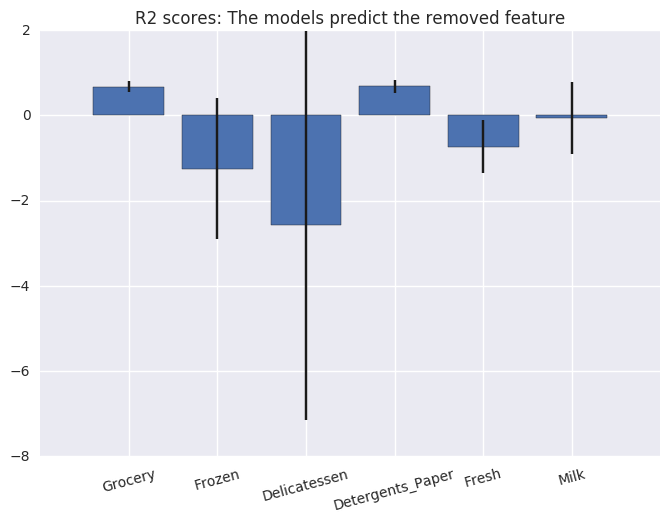

In [4]:
def feature_relevance(X):
    from sklearn.cross_validation import cross_val_score,ShuffleSplit
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.metrics import r2_score,make_scorer
    mean = dict()
    std = dict()
    for col,coldata in X.iteritems():
        # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
        new_data = X.drop(col,axis=1)
        # Split the data into training and testing sets using the given feature as the target
        ss = ShuffleSplit(X.shape[0],n_iter=100, test_size=0.25,random_state=rand_state_c)
        scorer = make_scorer(r2_score)
        # Create a decision tree regressor and fit it to the training set
        regressor = DecisionTreeRegressor(random_state = rand_state_c)       
        scores = cross_val_score(regressor,new_data,coldata,scoring=scorer,cv=ss)
        mean[col] = np.mean(scores)
        std[col] = np.std(scores)
    return mean,std
# Report the score of the prediction using the testing set
mean,std = feature_relevance(data)
print mean
plt.bar(range(len(mean)), mean.values(),yerr=std.values(), align='center', ecolor="k")
plt.xticks(range(len(mean)), mean.keys(), rotation=15)
plt.title("R2 scores: The models predict the removed feature")
plt.show()

### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**<br>
I attempt all features to predict. The prediction score is recorded below.<br>
 
 | Features         |      R^2 score      |
 | ---------------- | :-----------------: |
 | Delicatessen     | -2.5820             |
 | Detergents_Paper | 0.6817              |
 | Fresh            | -0.7329             |
 | Frozen           | -1.2454             |
 | Grocery          | 0.6783              |
 | Milk             | -0.0588             |
 
1. I attempt to predict Detergents_Paper.
2. The reported prediction score was 0.6817
3. Detergents_Paper seems like unnecessary for identifying customer's spending habits because Detergents_Paper can be easily predicted from other feature; Detergents_Paper doesn't provide many additional relevance informations.

But, in my opinion, all features might be necessary for identifying although some feature seem seem unrelated to other features. It needs more imformations and processing to decide because relevance and usefulness are different. As the histograms of features above, I thought some features, whose scores are greater than zero, are more lucky when all features never been scaled because whose distributions are also skewed.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

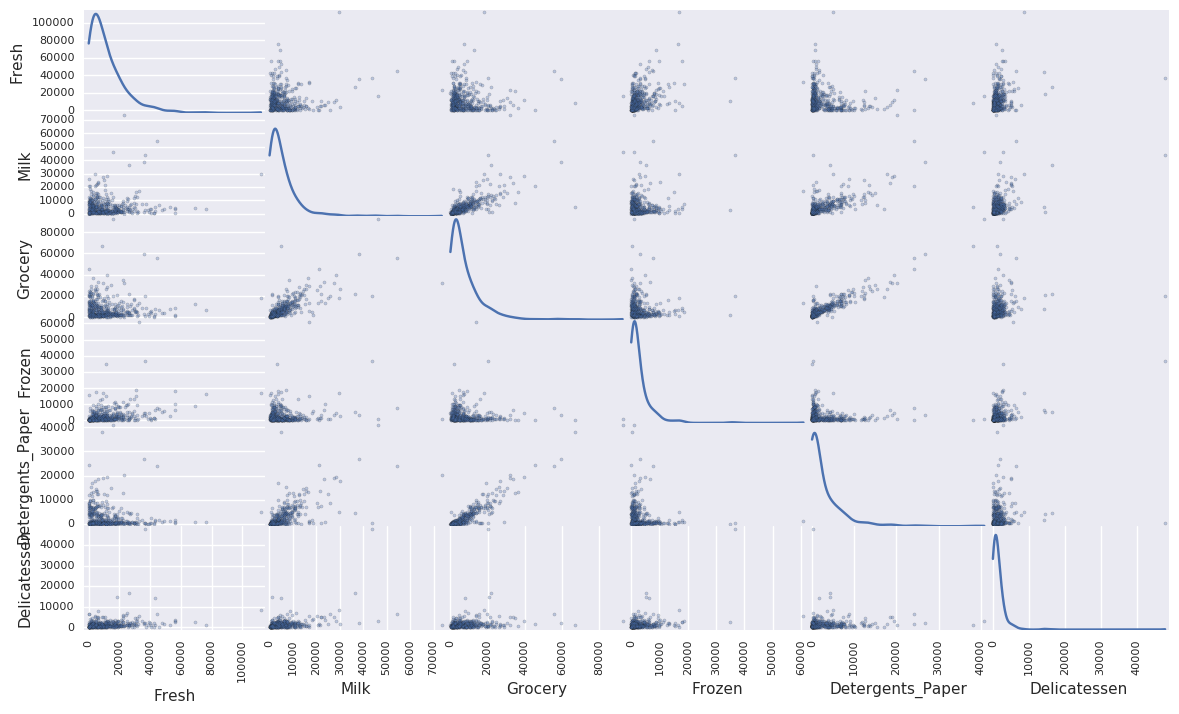

In [5]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**<br>
There is pair of Detergents_Paper and Grocery which exhibit some degree of correlation. This might confirm my  suspicions about the relevance of the 'Detergents_Paper' feature I attempted to predict because 'Detergents_Paper' might be redundant to some extent of 'Grocery'. As mentioned earlier, This relevance is incredibility because the data is not normally distributed. Most of the data points lie on right. 

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

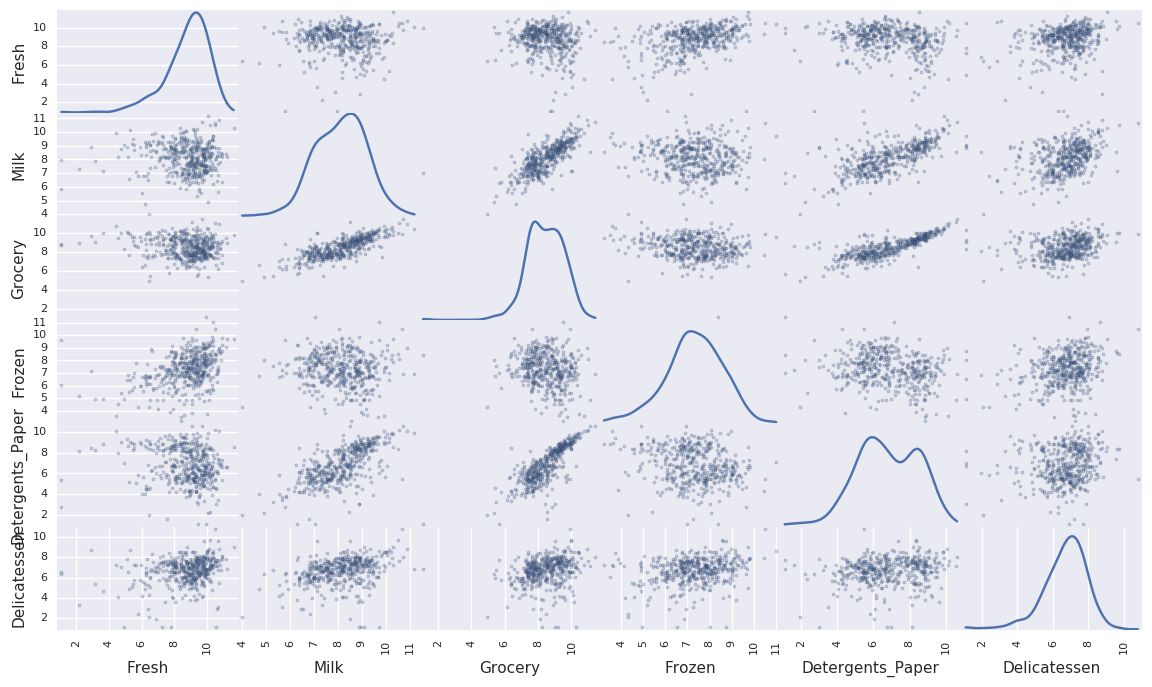

In [6]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [7]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
1,6.542472,9.051696,9.260843,6.093570,8.840291,5.049856
2,8.874728,7.794823,6.549651,8.750841,5.978886,6.814543


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


[128, 154, 65, 66, 75]

Remove 1.13636363636% outliers.


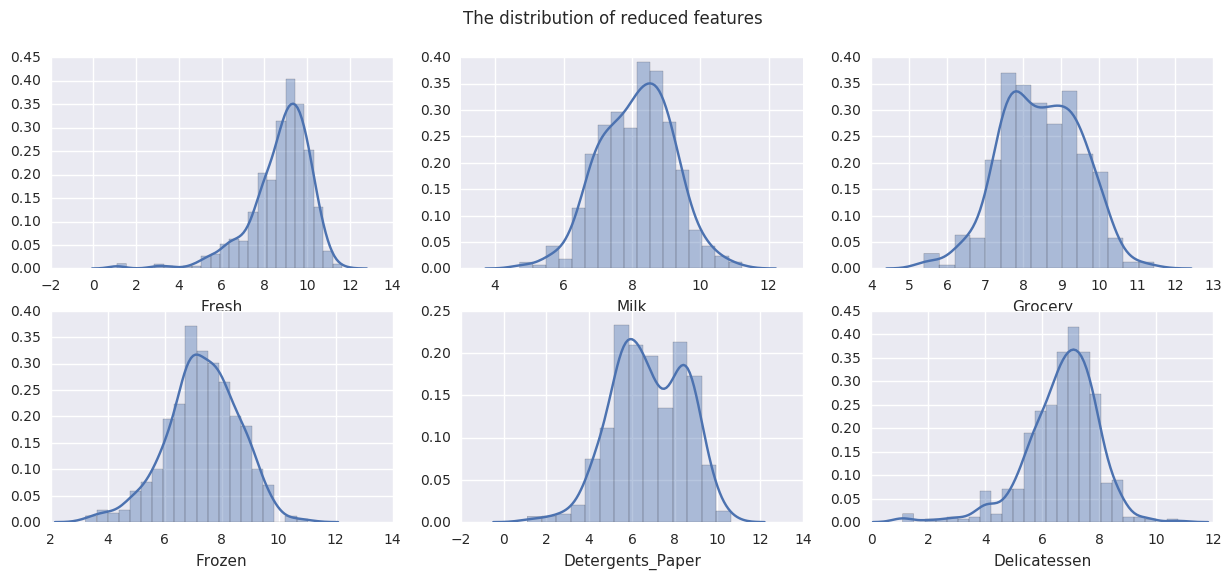

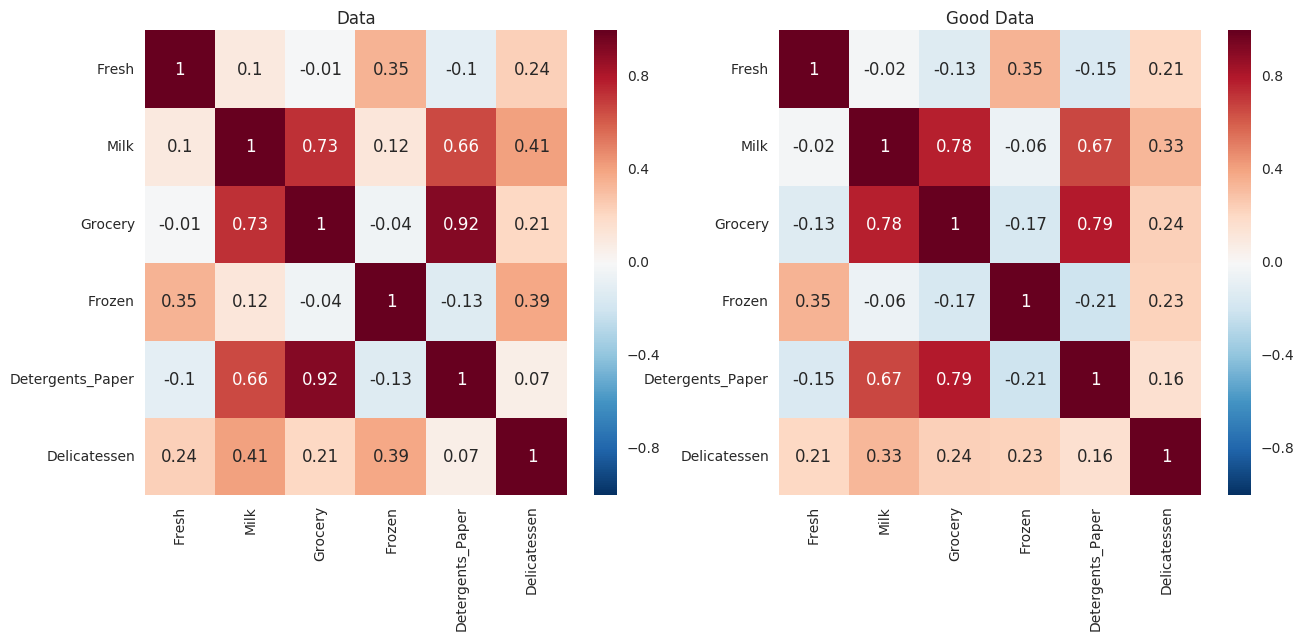

In [8]:
#outliers_index = set()
outliers_list = list()
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature],25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature],75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    outlier = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(outlier)
    outliers_list.extend(outlier.index.values)
    
# OPTIONAL: Select the indices for data points you wish to remove
from collections import Counter
outliers= [item for item, count in Counter(list(outliers_list)).items() if count > 1]
display(outliers)
#outliers = list(outliers_index)
print "Remove {}% outliers.".format(float(len(outliers))/log_data.shape[0]*100)
# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

fig, axs = plt.subplots(2,3, figsize=(15, 6))
fig.suptitle("The distribution of reduced features")
axs = axs.ravel()
for i in range(6):
    col = good_data.columns[i]
    sns.distplot(good_data[col], ax=axs[i])
plt.show()
fig, axs = plt.subplots(1,2,figsize=(15, 6))
axs = axs.ravel()
data_name = ["Data","Good Data"]
for i,cur_data in enumerate([data,good_data]):
    axs[i].set_title(data_name[i])
    sns.heatmap(cur_data.corr().round(decimals=2),annot=True, ax=axs[i])

### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**<br>
Almost 1.136%(5) of data points considered outliers for geater than one feature based on the definition above. These data points should definitely be removed from the dataset because the data points seriously affect the distribution of data. The figure above shows the skewing is fixed by removing outliers. The visualization and comparison of original data and processed data above show that the pairwise correlation of columns became quite distinct.  

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

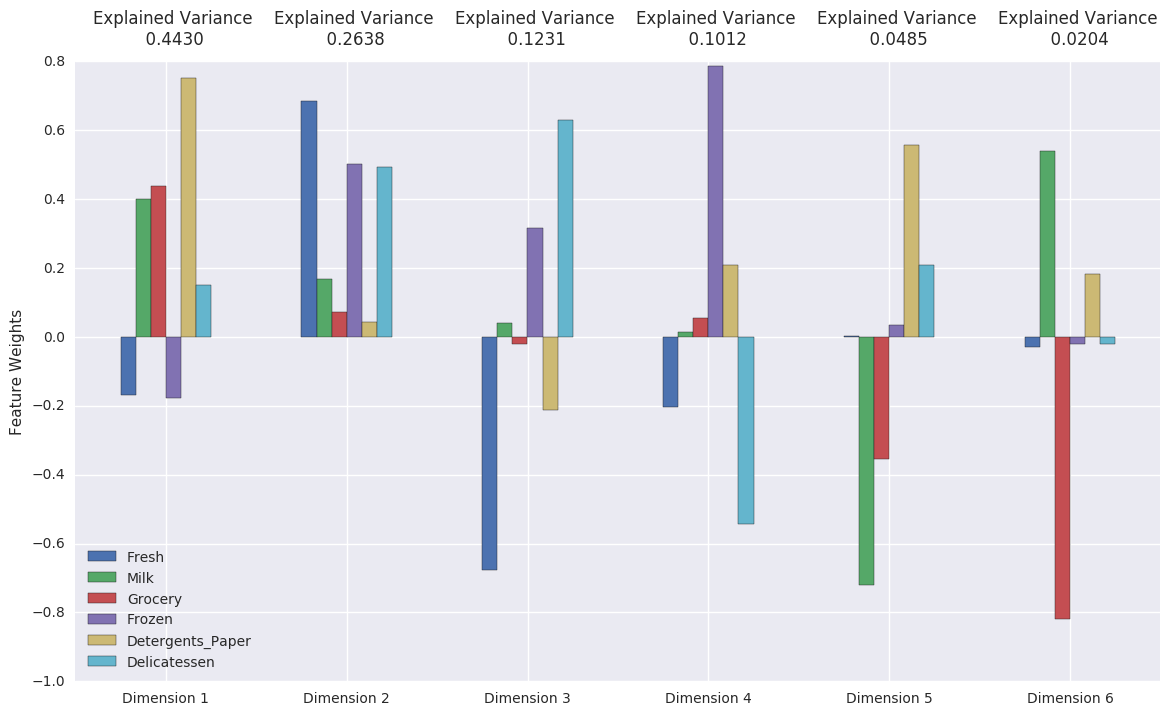

In [9]:
# Import PCA
from sklearn.decomposition import PCA
# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6).fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

In [10]:
def visualize_var_rat(pca):
    variances_rat = pca.explained_variance_ratio_
    variances = pca.explained_variance_
    bar_width = 0.4
    index = np.arange(len(variances_rat))
    rects_v = plt.bar(index, variances_rat,bar_width,color='r')
    rects_cv = plt.bar(index + bar_width, np.cumsum(variances_rat), bar_width,color='g')
    plt.ylabel('Explained variance ratio')
    xticks =tuple()
    for var,cum_var in zip(variances,np.cumsum(variances)):
        xticks = xticks + ('%.4f(cum:%.4f)' %(var,cum_var),)
    plt.xticks(index + bar_width,xticks,rotation=10)
    plt.legend((rects_v[0], rects_cv[0]),\
               ('Explained variance ratio', 'Cumulative Explained variance ratio'),\
               mode="expand")
    for rect_v,rect_cv in zip(rects_v,rects_cv):
        plt.text(rect_v.get_x() + rect_v.get_width()/2., 1.02*rect_v.get_height(),
                '%.4f' % (rect_v.get_height()),ha='center', va='bottom',fontsize=9)
        plt.text(rect_cv.get_x() + rect_cv.get_width()/2., 1.02*rect_cv.get_height(),
                '%.4f' % (rect_cv.get_height()),ha='center', va='bottom',fontsize=9)
    plt.show()

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

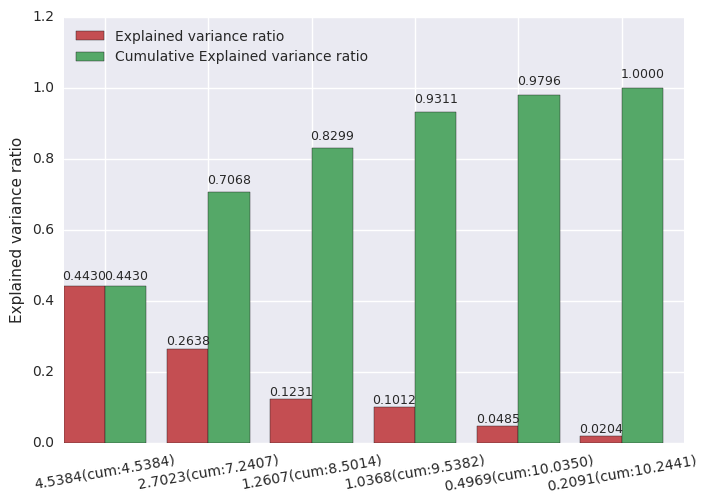

In [11]:
visualize_var_rat(pca)

**Answer:**<br>
Around 70.68% in the data is explained in total by the first and second principal components. Around 93.11% in the data is explained in total by the first four principal components.
1. In the visualization above, the increases of the Detergents_Paper, Grocery, Delicatessen and Milk corresponds and the decrease of the Fresh and Frozen of the with an positive increase in the first principal component. Therefore, the first principal component might present how much the customer spends ready-made goods.
2. In the same way, the 2nd principal component describes how much the customer spends foods because the increase of foods(Fresh, Frozen and Delicatessen) that most correspond with an positive inscrease in 2nd pricipal component. 
3. The positve increases in 3rd and 4th pricipal component corresponds Delicatessen and Frozen respectively. Therefore 3rd and 4th pricipal component describe what kind of foods the customer sell.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [12]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,4.1959,-1.2535,2.9398,-0.4817,-0.3075,0.4151
1,2.6007,-2.6568,-0.3255,0.8636,-0.1998,0.3368
2,-1.8415,0.6217,0.6492,0.7504,0.5338,1.2031


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [13]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)
pca3D = PCA(n_components=3).fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)
reduced3D_data = pca3D.transform(good_data)
# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)
pca3D_samples = pca3D.transform(log_samples)
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
reduced3D_data = pd.DataFrame(reduced3D_data, columns = ['Dimension 1', 'Dimension 2','Dimension 3'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [14]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,4.1959,-1.2535
1,2.6007,-2.6568
2,-1.8415,0.6217


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

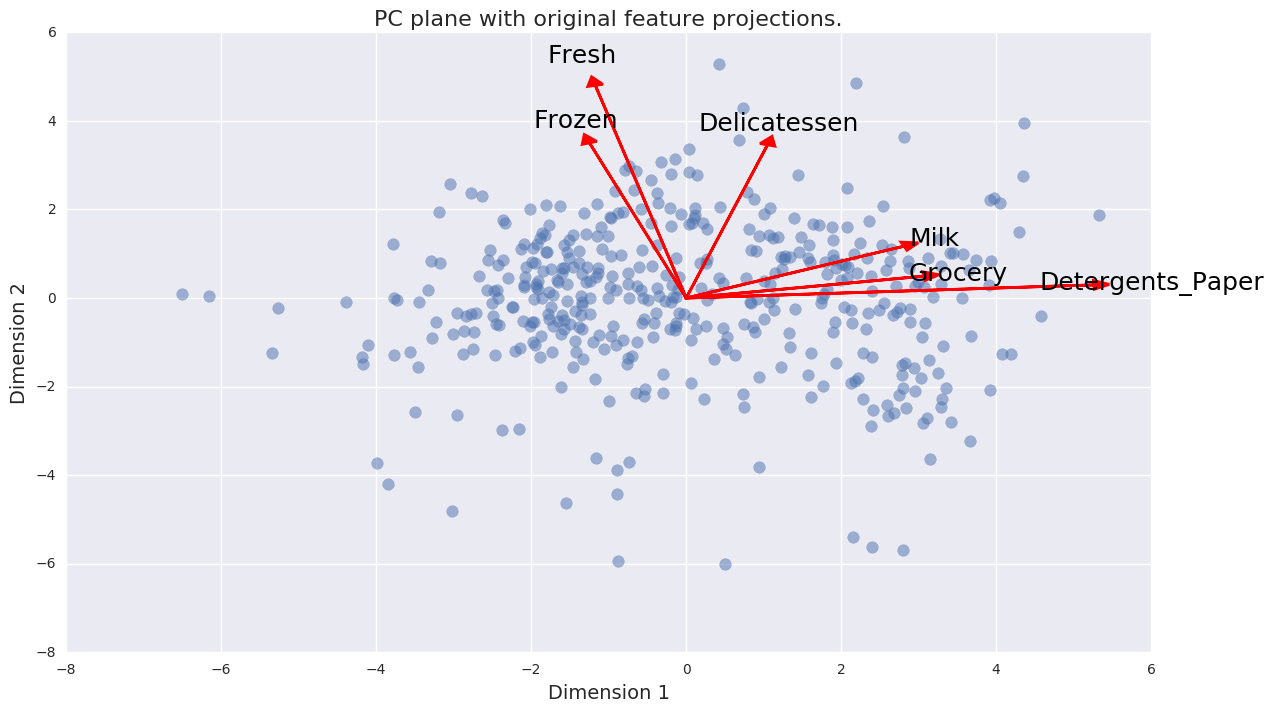

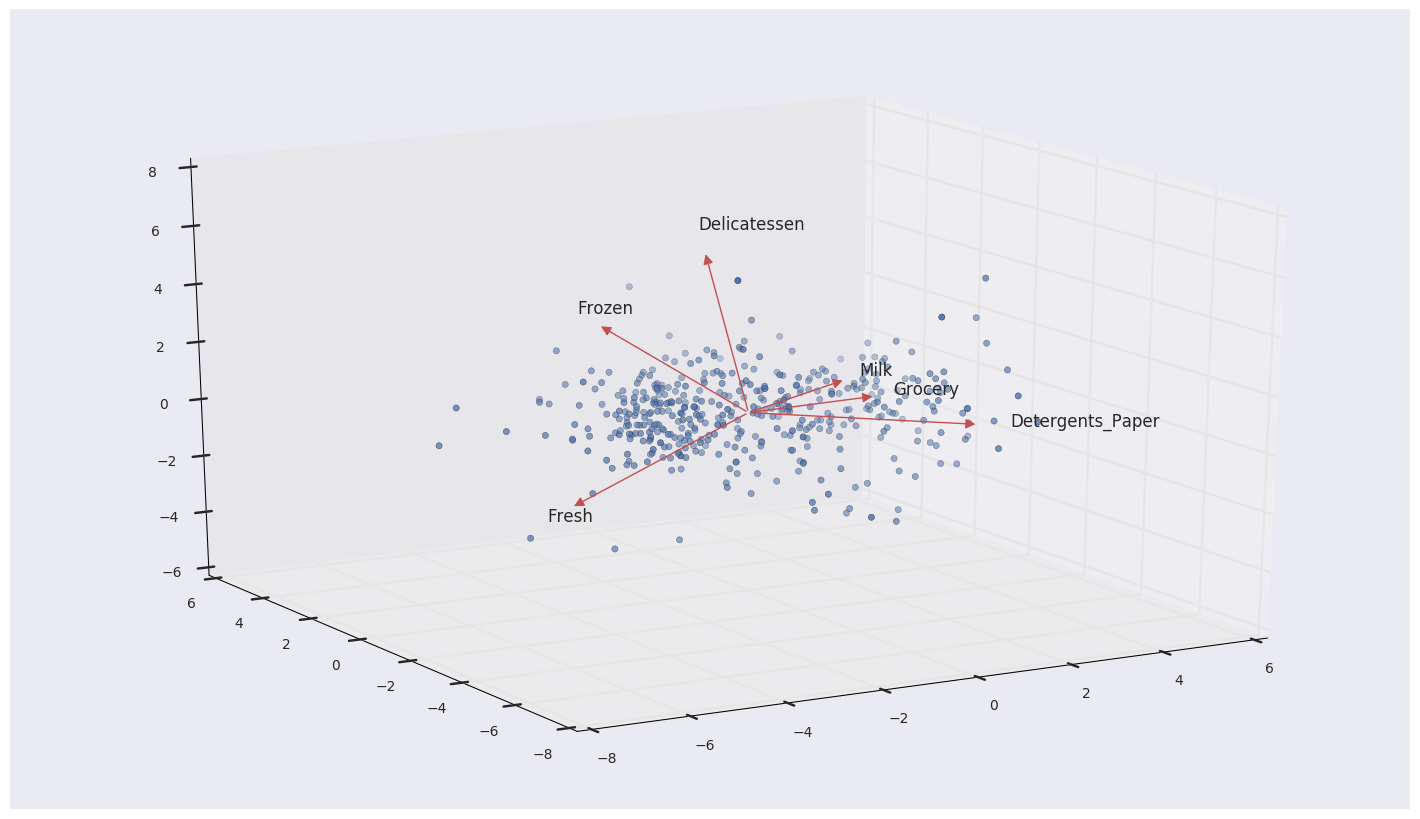

In [15]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)
# 3D biplot
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
#
def biplot3D(origin_data,reduced3D_data,pca3D):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(14,8))
    ax = Axes3D(fig)

    # scatterplot of the reduced data    
    ax.scatter(reduced3D_data['Dimension 1'],\
               reduced3D_data['Dimension 2'],\
               reduced3D_data['Dimension 3'])    
    feature_vectors = pca3D.components_.T
    # projections of the original features
    for i, v in enumerate(feature_vectors):
        vec = v*7;
        pos = v*8
        a = Arrow3D([0,vec[0]],[0,vec[1]],[0,vec[2]], mutation_scale=20, lw=1, arrowstyle="-|>", color="r")
        ax.add_artist(a)
        ax.text(pos[0],pos[1],pos[2],origin_data.columns[i])
    ax.view_init(20, 240)
    return ax

biplot3D(good_data,reduced3D_data,pca3D)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**<br>
The advantages of using K-Means clustering are as follows:<br>
1. K-means is usually faster than GMM because K-means just calculates the mean instead of the parameters of a gaussian distribution.
2. K-means is simpler than GMM, K-means just need 1 parameter that is the number of clusters.

The advantages of using GMM clustering are as follows:<br>
1. GMM is more flexible because it's a soft clustering method, data points can potentially belong to multiple clusters.

I will use k-means because my observations abouts the wholesale customer data so far not enough to have robust estimates. I need to adjust this model frequently. Thus I perfer the algorithm that is fast and simple at the start.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

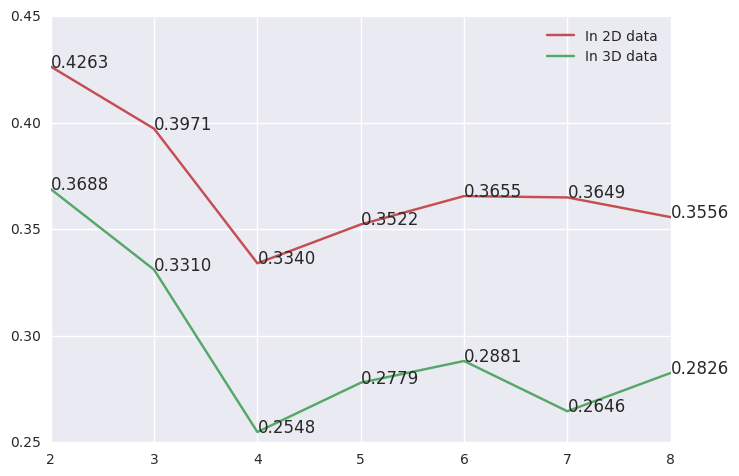

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Apply your clustering algorithm of choice to the reduced data 
clusterer = KMeans(n_clusters=2, random_state=65535).fit(reduced_data)
clusterer3D = KMeans(n_clusters=2, random_state=65535).fit(reduced3D_data)
# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)
preds3D = clusterer3D.predict(reduced3D_data)
# Find the cluster centers
centers = clusterer.cluster_centers_
centers3D = clusterer3D.cluster_centers_
# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)
sample_preds3D = clusterer3D.predict(pca3D_samples)
# Calculate the mean silhouette coefficient for the number of clusters chosen
def score_num_cluster(data,test_range):
    score = dict()
    for i in test_range:
        clusterer = KMeans(n_clusters=i, random_state=65535).fit(data)
        pred = clusterer.predict(data)
        score[i] = silhouette_score(data, pred)
    return score
test_range = range(2,9)
scores = score_num_cluster(reduced_data,test_range) 
scores3D = score_num_cluster(reduced3D_data,test_range) 
handle2d = plt.plot(scores.keys(),scores.values(),color='r',label='In 2D data')
handle3d = plt.plot(scores3D.keys(),scores3D.values(),color='g',label='In 3D data')
for x,y in zip(test_range, scores.values()):                                       
    plt.annotate('%.4f' % y, xy=(x,y)) 
for x,y in zip(test_range, scores3D.values()):                                       
    plt.annotate('%.4f' % y, xy=(x,y)) 
plt.legend()
plt.show()

### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**<br>

| Nmber of cluster | Silhouette score | Silhouette score in 3D |
|-----------------:|------------------|------------------------|
|      2(**Best**) |           0.4471 | 0.3905                 |
| 3                |           0.3639 | 0.2957                 |
| 4                |           0.3311 | 0.2543                 |
| 5                |           0.3527 | 0.2737                 |
| 6                |           0.3627 | 0.2917                 |
| 7                |           0.3549 | 0.2830                 |

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

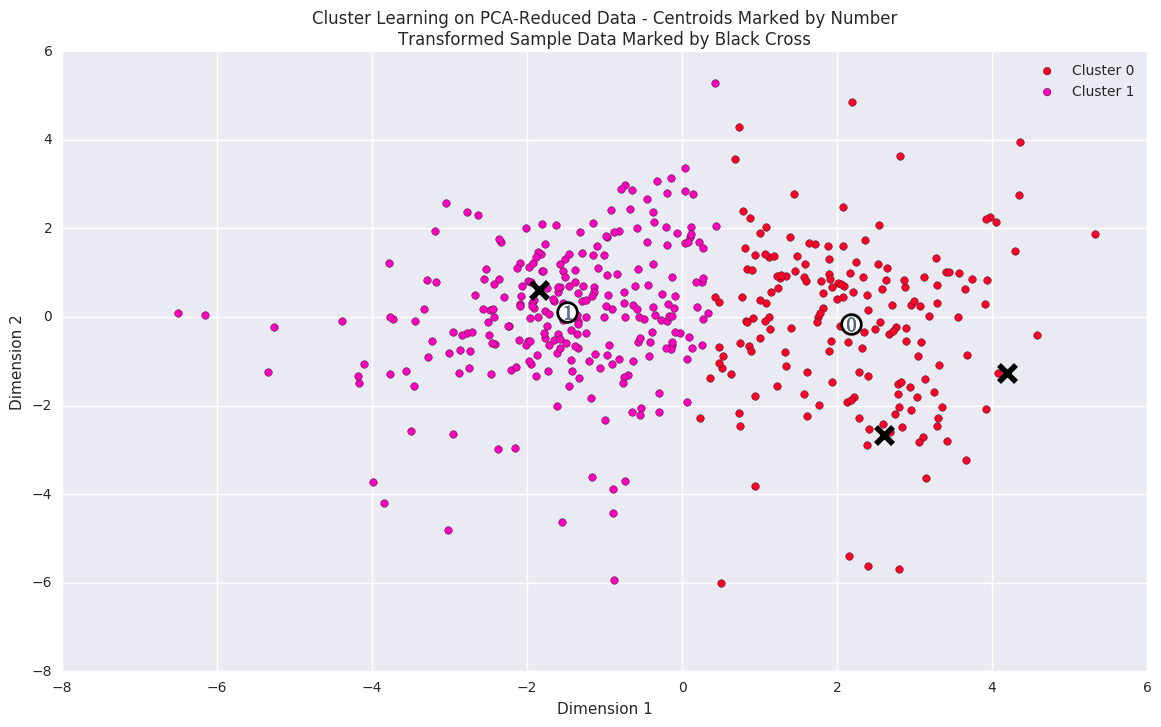

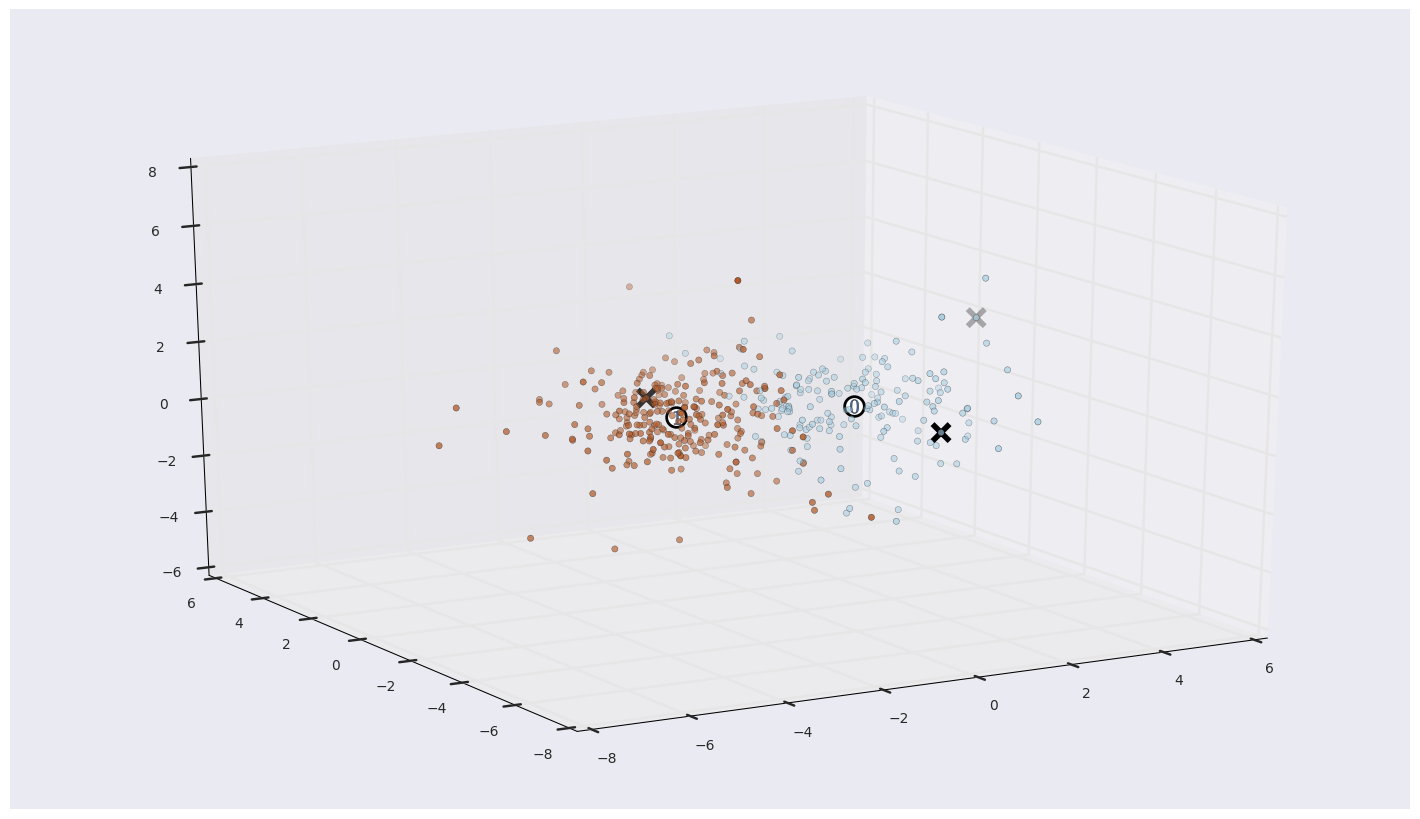

In [17]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)
def cluster_results3D(reduced3D_data,preds3D, centers3D, pca3D_samples):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(14,8))
    ax = Axes3D(fig)
    # scatterplot of the reduced data    
    ax.scatter(reduced3D_data['Dimension 1'],\
               reduced3D_data['Dimension 2'],\
               reduced3D_data['Dimension 3'],c=preds, cmap=plt.cm.Paired)
    for i, c in enumerate(centers3D):
        ax.scatter(c[0], c[1], c[2],\
                   color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(c[0], c[1], c[2],\
                   marker='$%d$'%(i), alpha = 1, s=100);
    ax.scatter(pca3D_samples[:,0], pca3D_samples[:,1], pca3D_samples[:,2],\
               s = 150, linewidth = 4, color = 'black', marker = 'x');
    ax.view_init(20, 240)
    return ax
cluster_results3D(reduced3D_data,preds3D,centers3D,pca3D_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [18]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)
log_centers3D = pca3D.inverse_transform(centers3D)
# Exponentiate the centers
true_centers = np.exp(log_centers)
true_centers3D = np.exp(log_centers3D)
# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
segments3D = ['Segment3D {}'.format(i) for i in range(0,len(centers3D))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers3D = pd.DataFrame(np.round(true_centers3D), columns = data.keys())
true_centers.index = segments
true_centers3D.index = segments3D
display(true_centers)
display(true_centers3D)
ori_good_data = data.drop(data.index[outliers]).reset_index(drop = True)
ori_good_data = pd.DataFrame(np.round(ori_good_data), columns = data.keys())
display(ori_good_data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,4005.0,7900.0,12104.0,952.0,4561.0,1036.0
Segment 1,8867.0,1897.0,2477.0,2088.0,294.0,681.0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment3D 0,4107.0,7826.0,12113.0,903.0,4658.0,957.0
Segment3D 1,8690.0,1919.0,2490.0,2159.0,293.0,720.0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,12089.372414,5788.103448,7911.158621,3096.126437,2848.473563,1536.797701
std,12662.796341,7374.172350,9365.740973,4873.769559,4679.364623,2833.363881
min,3.000000,112.000000,218.000000,25.000000,3.000000,3.000000
25%,3208.000000,1579.500000,2156.000000,770.500000,260.000000,411.500000
50%,8565.000000,3634.000000,4757.000000,1541.000000,813.000000,967.000000
75%,16934.500000,7168.000000,10665.500000,3559.500000,3935.000000,1825.500000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**<br>
1. The customer segment 0 represent that the customer in cluster 1 purchases large amounts of ready-made. The number of all kinds of ready-made were above 75% customers but Delicatessen in the data without outliers. Therefore, the customer segment 1 might be a hypermarket.
2. The customer segment 1 represent that the customer in cluster 0 spends a lot of unprocessed food. Fresh and Frozen was spent 8867 and 2088 respectively above 50% cumstomers in the data without outliers. Therefore, the customer segment 0 might be a restaurant.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [19]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred
display(samples)

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,200,25862,19816,651,8773,6250
1,694,8533,10518,443,6907,156
2,7149,2428,699,6316,395,911


**Answer:**<br>
1. Sample point 0 is represented by segments 0. Sample point 0 spends extraordinarily on Milk, and spends highly on Grocery, Detergents_Paper and delicatessen that makes the customer more like a hypermarket and that should be in cluster 0.
2. Sample point 1 is represented by segments 0. Sample point 1 spends highly on Milk, Grocery, Detergents_Paper and delicatessen that makes the customer more like a grocery store and that should be in cluster 0.
2. Sample point 2 is represented by segments 1. Sample point 2 spends highly on unprocessed foods that makes the customer more like a restaurant  and that should be in cluster 1.

Yes, the predictions for each sample point consistent with this, that are similar to the intuition in **Question 8**.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**<br>
The wholesale distributor can use the customer segments to determine what types of customers are affected most by the chagnes, if the cumstomers belong in cluster 1, it wouldn't react positively to the change in delivery service. Because, the customers purchase mainly fresh food, which should be fresh and daily delivered. The A/B tests might hurt the company's reputation when making changes to delivery service from currently five days a week to three days a week.
To reduce risk, the wholesale distributor would run A/B tests on the customers that picked from cluster 0.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**<br>
The wholesale distributor can label the new customers using a supervised learner, which coulde be used to train on the original customers. And, the targer variable would be the customer segment as an engineered feature for the data. The supervised learner will classify new customers into two cluster by the features: 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', and 'Delicatessen'.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

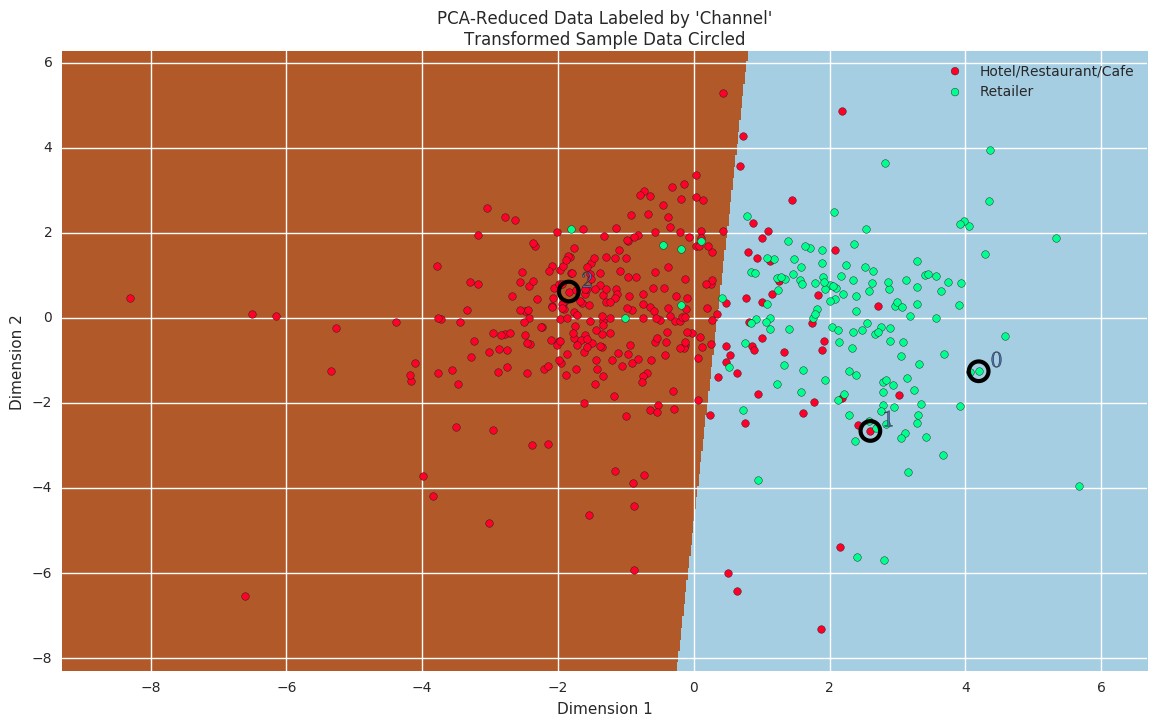

In [20]:
# Display the clustering results based on 'Channel' data
#vs.channel_results(reduced_data, outliers, pca_samples)
def kmean_channel_results(origin_data, pca, samples, kmeans):
    # Check that the dataset is loadable
    try:
        full_data = pd.read_csv("customers.csv")
    except:
        print "Dataset could not be loaded. Is the file missing?"
        return False
    # Create the Channel DataFrame
    reduced_data = pd.DataFrame(pca.transform(origin_data), columns = ['Dimension 1', 'Dimension 2'])
    channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
    #channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
    labeled = pd.concat([reduced_data, channel], axis = 1)
    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))
    #
    cmap = plt.cm.get_cmap('gist_rainbow')
    labels = ['Hotel/Restaurant/Cafe', 'Retailer']
    grouped = labeled.groupby('Channel')
    for i, channel in grouped:
        channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2',
                     color = cmap((i-1)*1.0/2), label = labels[i-1], s=30)
    for i, sample in enumerate(samples):
        ax.scatter(x = sample[0], y = sample[1],
                   s = 200, linewidth = 3, color = 'black', marker = 'o', facecolors = 'none')
        ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), alpha = 1, s=125)
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data['Dimension 1'].min() - 1, reduced_data['Dimension 1'].max() + 1
    y_min, y_max = reduced_data['Dimension 2'].min() - 1, reduced_data['Dimension 2'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.imshow(Z, interpolation='nearest',
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=plt.cm.Paired,
              aspect='auto', origin='lower')
    # Title
    ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");
kmean_channel_results(log_data,pca,pca_samples,clusterer)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**<br>
The clustering algorithm and number of clusters I've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers, the clustering algorithm's performence is tolerable. There are customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution. But, the clustering algorithm might be suffered from over-fitting. According to sample point 1, the inductive bias refers outliers. The distribution of customers as 'Hotels/Restaurants/Cafes' is discrete, it's hard to cluster purely , therefore soft assignment could provide more suggestion by assigning a probability according to the relative distance from the centroid of each cluster.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.